In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import numpy as np
import torch
import pandas as pd
from math import sqrt
import os

import sys

import viz_config

sys.path.append('../..')
# sys.path.append('../')

import optimneuralts
from utils import *
torch.set_default_tensor_type("torch.FloatTensor")

saves_path = '../saves'

fm = matplotlib.font_manager.json_load("/home/quoding/.cache/matplotlib/fontlist-v330.json")
print(fm.findfont("serif", rebuild_if_missing=False))
print(fm.findfont("serif", fontext="afm", rebuild_if_missing=False))

/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/afm/pncr8a.afm


In [28]:
def compute_n_inter(tens1:torch.Tensor, tens2:torch.Tensor):
    set1 = tens1.unique(dim=0).tolist()
    set2 = tens2.unique(dim=0).tolist()
    
    set1 = set([tuple(item) for item in set1])
    set2 = set([tuple(item) for item in set2])

    inter = set1 & set2
    n_inter = len(set1 & set2)
    percent_of_set1_in_set2 = np.float32(n_inter) / np.float32(len(set1))

    return n_inter, percent_of_set1_in_set2

In [52]:
figsize = viz_config.set_size(443)

l = os.listdir('../saves/')
labels_fn = "instance_difficile"

l = [i for i in l if i.startswith("DE_")]
l = [i for i in l if 'skew0' not in i]
l = sorted(l)
experiments = l

Ns = [int(i.split('warmup')[1].split('_')[0]) for i in l]
datasets = [i.split("bs")[0][:-1] for i in l]
nus = [fr", $\nu = {i.split('expl')[1]}$" if '30000' not in i else '' for i in l]
labels = [fr"Instance = Réaliste, $N = {Ns[idx]}${nus[idx]}" if 'skew0' in l[idx] else fr"Instance = Difficile, $N = {Ns[idx]}${nus[idx]}" for idx in range(len(datasets))]

# styles = ['-o.' if "Difficile" in label else '-.' for label in labels]
styles = ['-' for label in labels]
colors = ["tab:orange", "tab:purple", "tab:green", "tab:red", "tab:cyan", "tab:brown"] * 2
interval = 200
upper_lim = 30100

In [53]:
prefix = "memoire"
n_trials = 30000
n_runs = 25
metrics_dict = {}
metrics = [
    "recalls",
    "recalls_alls",
    "precisions_alls",
    "precisions",
    "ratio_found_pats",
    "ratio_found_pats_alls",
    "losses",
    "dataset_losses",
    "n_inter_alls",
    "all_flagged_risks",
    "agents",
    "all_flagged_combis_idx",
]
metric_to_ylabel = {}
for exp in experiments:
    metrics_dict[exp] = {}
    for metric in metrics:
        metrics_dict[exp][metric] = []
        for run in range(n_runs):
            path = f"{saves_path}/{exp}/{metric}/{run}.pth"
            metrics_dict[exp][metric].append(torch.load(path, map_location=torch.device("cpu")))


        # Do metrics to ylabel dict
        if 'recall' in metric:
            metric_to_ylabel[metric] = "Rappel"
        elif 'precision' in metric:
            metric_to_ylabel[metric] = "Précision"
        elif 'ratio_found_pats' in metric:
            metric_to_ylabel[metric] = "Ratio $\mathcal{P}$"
        elif 'losses' in metric:
            metric_to_ylabel[metric] = "Perte"

[]


/tmp/ipykernel_186863/3692856119.py:30: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  means = [0] if np.isnan(means) else means


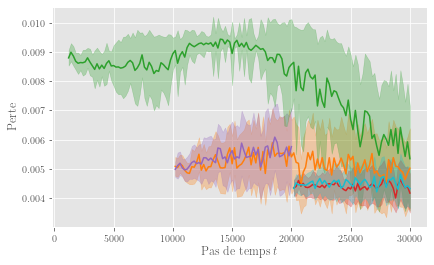

In [57]:
metrics_to_eval = [
    # "recalls",
    # "recalls_alls",
    # "precisions_alls",
    # "precisions",
    # "ratio_found_pats",
    # "ratio_found_pats_alls",
    # "losses",
    "dataset_losses",
]

for metric in metrics_to_eval:
    fig, ax2 = plt.subplots(1, 1, figsize=figsize)

    for i, exp in enumerate(list(metrics_dict.keys())):
        means = np.nanmean(metrics_dict[exp][metric], axis=0)
        stds = np.nanstd(metrics_dict[exp][metric], axis=0)
        x = np.arange(len(means)) * interval + Ns[i]

        if Ns[i] != 30000:
            if metric == 'dataset_losses': # Usually dataset loss is monitored during agent rollouts, not before.
                x += interval
            ax2.plot(x, means, styles[i], color=colors[i], label=labels[i])
            ax2.fill_between(
                x,
                np.clip(means - stds, 0, 1),
                np.clip(means + stds, 0, 1),
                color=colors[i],
                alpha=0.3,
            )
        else:
            means = [0] if np.isnan(means) else means
            ax2.scatter(x, means, color=colors[i], label=labels[i])

    ax2.set_ylabel(metric_to_ylabel[metric])
    ax2.set_xlabel("Pas de temps $t$")

    fig.tight_layout()
    fig.savefig(
        f"images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}.pdf", format="pdf"
    )


In [55]:
handles, labels = ax2.get_legend_handles_labels()
leg = plt.figure("legend")
leg.legend(handles, labels, loc='center')
leg.savefig('images/polypharmacy/perf/legend.pdf', format='pdf')


<Figure size 432x288 with 0 Axes>

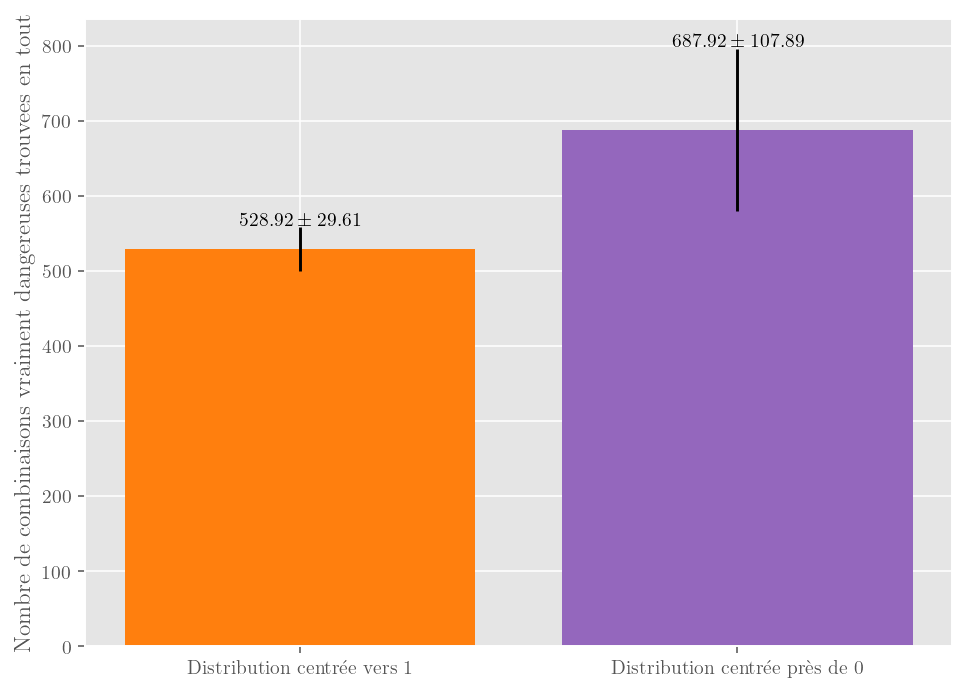

In [52]:
# Plot ratio found pat
metric = "n_inter_alls"
n_inter_means = []
n_inter_stds = []

for i, exp in enumerate(experiments):
    n_inters = []
    for j in range(n_runs):
        n_inters.append(metrics_dict[exp][metric][j][-1])

    n_inters = np.array(n_inters)
    mean = np.nanmean(n_inters)
    n_inter_means.append(mean)
    n_inter_std = np.nanstd(n_inters)
    n_inter_stds.append(n_inter_std)

fig, ax = plt.subplots()
p1 = ax.bar(list(range(len(labels))), n_inter_means, yerr=n_inter_stds, color=colors)

# plt.xlabel('Graine aleatoire')
ax.set_xticks(list(range(len(labels))), labels=labels)
ax.set_ylabel("Nombre de combinaisons vraiment dangereuses trouvees en tout")
ax.bar_label(p1, labels=[f"${m:.2f} \pm {s:.2f}$" for m, s in zip(n_inter_means, n_inter_stds)])
plt.tight_layout()
plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}.pdf', format="pdf")


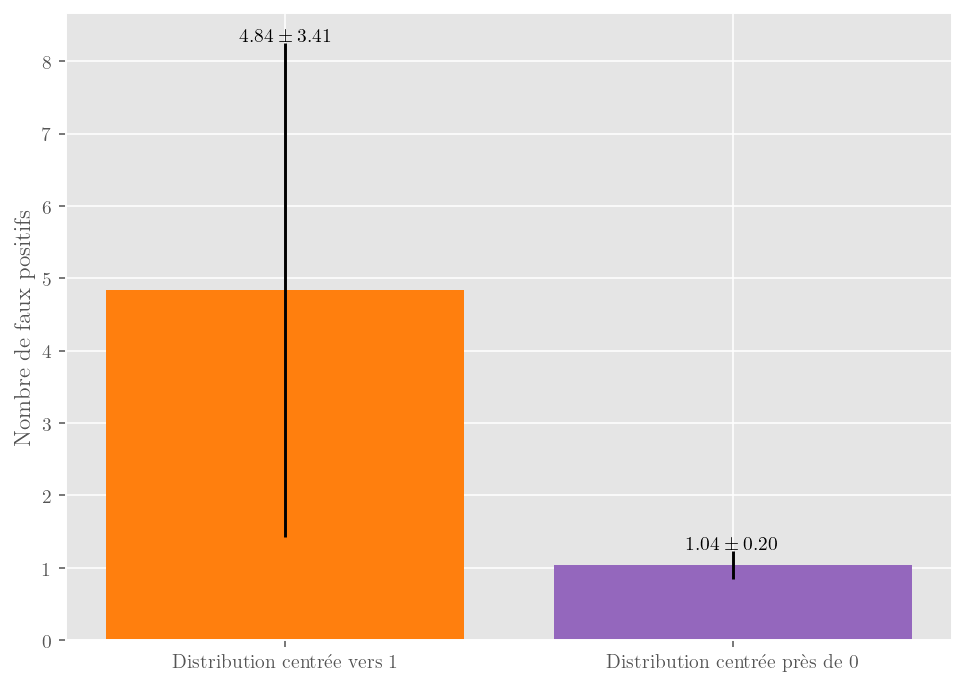

In [53]:
# Plot ratio found pat
metric = "all_flagged_risks"
thresh = 1.1
means = []
stds = []
for i, exp in enumerate(experiments):
    n_flagged_below_thresh = []
    for j in range(n_runs):
        # n_total_flagged = sum(metrics_dict[exp][metric][j])
        if metrics_dict[exp][metric][j].nelement() == 0:
            continue
        n = sum(metrics_dict[exp][metric][j] < thresh)
        n_flagged_below_thresh.append(n.item())

    seeds = np.arange(len(n_flagged_below_thresh))
    n_flagged_below_thresh = np.array(n_flagged_below_thresh)
    mean = np.nanmean(n_flagged_below_thresh)
    std = np.nanstd(n_flagged_below_thresh)

    means.append(mean)
    stds.append(std)


fig, ax = plt.subplots()
p1 = ax.bar(list(range(len(labels))), means, yerr=stds, color=colors)
# plt.xlabel('Graine aleatoire')
ax.set_xticks(list(range(len(labels))), labels=labels)
ax.set_ylabel("Nombre de faux positifs")
ax.bar_label(p1, labels=[f"${m:.2f} \pm {s:.2f}$" for m, s in zip(means, stds)])

plt.tight_layout()
plt.savefig(f"images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}_fauxpos.pdf", format="pdf")


In [54]:
def color_and_label_violinplot(violin, color, label):
    for pc in violin['bodies']:
        pc.set_color(color)

    violin["cbars"].set_color(color)
    # violin["cmeans"].set_color(color)
    violin["cmins"].set_color(color)
    violin["cmaxes"].set_color(color)
    
    fig_labels.append((mpatches.Patch(color=color), label))


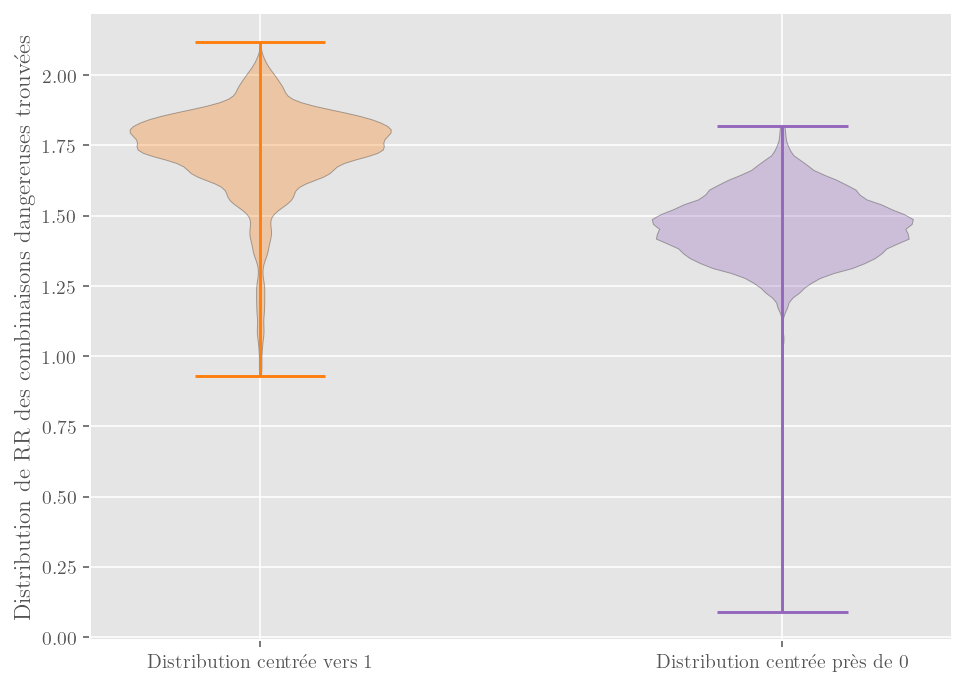

In [55]:
# Plot ratio found pat
fig_labels = []
metric = "all_flagged_risks"
all_flagged_risks_indiv = []
for i, exp in enumerate(experiments):
    all_flagged_risks_this_exp = []
    for j in range(n_runs):
        all_flagged_risks_this_exp.extend(metrics_dict[exp][metric][j].flatten().tolist())
    all_flagged_risks_indiv.append(all_flagged_risks_this_exp)

violin_plot = plt.violinplot(all_flagged_risks_indiv)
for i, pc in enumerate(violin_plot["bodies"]):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
violin_plot["cbars"].set_color(colors)
violin_plot["cmins"].set_color(colors)
violin_plot["cmaxes"].set_color(colors)

plt.xticks(list(range(1, len(labels) + 1)), labels)
plt.ylabel("Distribution de RR des combinaisons dangereuses trouvées")
plt.tight_layout()
plt.savefig(f"images/polypharmacy/perf/{prefix}_{metric}_where_flagged_{labels_fn}.pdf", format="pdf")


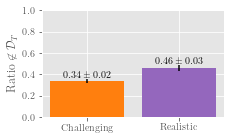

In [17]:
# Plot ratio found pat
metric = "all_flagged_combis_idx"
means, stds = [], []
for i, exp in enumerate(experiments):
    n_inter, percent_of_flagged_in_train = [], []
    combis, risks, pat_vecs, n_obs, n_dim = load_dataset(
        datasets[i], path_to_dataset="../datasets"
    )
    for j in range(n_runs):
        all_flagged_combis_idx = list(metrics_dict[exp][metric][j])
        all_flagged_combis = combis[all_flagged_combis_idx]
        training_set = metrics_dict[exp]["agents"][j].train_dataset.features
        inter, percent = compute_n_inter(all_flagged_combis, training_set)
        percent = 1 - percent
        n_inter.append(inter)
        percent_of_flagged_in_train.append(percent)

    means.append(np.nanmean(percent_of_flagged_in_train))
    stds.append(np.nanstd(percent_of_flagged_in_train))

fig, ax = plt.subplots(figsize=figsize)
p1 = ax.bar(list(range(len(labels))), means, yerr=stds, color=colors)
ax.set_xticks(list(range(len(labels))), labels=labels)
ax.set_ylabel(r"Ratio $\not\in\mathcal{D}_T$")
ax.set_ylim(0, 1)
ax.bar_label(p1, labels=[f"${m:.2f} \pm {s:.2f}$" for m, s in zip(means, stds)])

plt.tight_layout()
plt.savefig(
    f"images/polypharmacy/perf/{prefix}_can_we_use_replay_buffer_to_flag_{labels_fn}.pdf", format="pdf"
)
